<a href="https://colab.research.google.com/github/tngjody/bt4221-airfare-booking/blob/main/BT4221_Group_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H

In [20]:
# PySpark Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, isnan, datediff, lit
from pyspark.sql.types import NumericType, DoubleType, IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Others
from datetime import datetime

# 1. Data Loading & Preprocessing

In [30]:
# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
flight_df.show(5, truncate=False)

# Display schema
flight_df.printSchema()

# Total Count
flight_df.count()

+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------------------------------------------+-------------------------------+------------------------------------------------------------+--------------------------+----------------------------+-------------------+-------------------+------------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw                                    |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw                          

2000000

In [ ]:
date_cols = ['searchDate', 'flightDate']

# Convert columns to Date type using PySpark
for col_name in date_cols:
    if col_name in flight_df.columns:
        flight_df = flight_df.withColumn(col_name, F.to_date(F.col(col_name), "yyyy-MM-dd"))

# Create a new column 'airport_pair' by combining 'startingAirport' and 'destinationAirport'
flight_df = flight_df.withColumn("airport_pair", F.concat_ws("_", "startingAirport", "destinationAirport")) 

# Split the `segmentsAirlineCode` by '||' and count the number of elements (segments)
flight_df = flight_df.withColumn(
    "num_segments",
    F.size(F.split("segmentsAirlineCode", "\|\|"))  # Split the '||' and count the number of elements
) 

# List of festival dates
festivals = [
    "2023-01-01",  # New Year's Day
    "2023-01-22",  # Lunar New Year
    "2023-02-14",  # Valentine's Day
    "2023-03-17",  # St. Patrick's Day
    "2023-04-07",  # Good Friday
    "2023-04-09",  # Easter Sunday
    "2023-04-22",  # Earth Day
    "2023-05-01",  # International Workers' Day (May Day)
    "2023-06-29",  # Eid al-Adha
    "2023-07-04",  # Independence Day (USA)
    "2023-10-31",  # Halloween
    "2023-11-23",  # Thanksgiving (USA)
    "2023-12-25",  # Christmas Day
] 

festival_dates = [datetime.strptime(date, "%Y-%m-%d").date() for date in festivals]

festival_df = spark.createDataFrame([(date,) for date in festival_dates], ["festivalDate"])
festival_df = festival_df.withColumn("festivalDate", col("festivalDate").cast("date"))

# Perform a cross join and filter for flights near festivals
joined_df = flight_df.crossJoin(festival_df).filter(
    (datediff(col("flightDate"), col("festivalDate")) >= -1) & 
    (datediff(col("flightDate"), col("festivalDate")) <= 1)
)

# Create a temporary view with a clear column name to avoid ambiguity
temp_festival_flights = joined_df.select("legId", "flightDate").distinct().withColumn("isNearFestival", lit(1))

# Perform the join using the temporary view
flight_df = flight_df.join(
    temp_festival_flights,
    on=["legId", "flightDate"],
    how="left"
)

# Fill null values in isNearFestival with 0
flight_df = flight_df.fillna(0, subset=["isNearFestival"])
flight_df.show()

Py4JJavaError: An error occurred while calling o2031.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 785.0 failed 1 times, most recent failure: Lost task 0.0 in stage 785.0 (TID 3900) (10.249.52.129 executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.foreach(WholeStageCodegenEvaluatorFactory.scala:41)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.foreach(WholeStageCodegenEvaluatorFactory.scala:41)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)


# 2. Data Cleaning 

In [3]:
# Remove rows with null values

# Drop duplicates
flight_df = flight_df.dropDuplicates()

# Final Count
flight_df.count()

print(f"Number of rows after dropping duplicates: {flight_df.count()}")
print(f"Number of columns: {len(flight_df.columns)}")

Number of rows after dropping duplicates: 2000000
Number of columns: 27


In [ ]:
# Build expressions to count missing values (null and NaN for numeric columns; null only otherwise)
missing_exprs = []
for field in flight_df.schema.fields:
    if isinstance(field.dataType, NumericType):
        # For numeric columns, count both nulls and NaNs
        expr = sum((col(field.name).isNull() | isnan(col(field.name))).cast("int")).alias(field.name)
    else:
        # For non-numeric columns, count only nulls
        expr = sum(col(field.name).isNull().cast("int")).alias(field.name)
    missing_exprs.append(expr)

# Compute missing values count per column
missing_counts = flight_df.select(*missing_exprs)
missing_counts.show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

# 3. Data Exploration

In [32]:
# ===== Categorical Features Exploration using PySpark =====
categorical_cols = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isRefundable', 'isNonStop']

def explore_categorical(df, column):
    """Display ALL categories for a categorical column using PySpark.""" 
    category_counts = df.groupBy(column).agg(F.count("*").alias("count")).orderBy(F.col("count").desc())
    category_counts.show(1000, truncate=False)  # Show all values 

# Explore frequency counts for categorical columns
for col_name in categorical_cols:
    explore_categorical(flight_df, col_name) 

# ===== Fare Distribution by Airline using PySpark =====
if 'segmentsAirlineCode' in flight_df.columns:
    # Extract the first airline code for each flight
    flight_df = flight_df.withColumn('primaryAirline', F.split(F.col('segmentsAirlineCode'), r'\|\|').getItem(0)) 
    
    # Calculate fare statistics by airline
    airline_stats = flight_df.groupBy("primaryAirline").agg(
        F.count("*").alias("count"),
        F.mean("baseFare").alias("mean_fare"),
        F.stddev("baseFare").alias("stddev_fare"),
        F.min("baseFare").alias("min_fare"),
        F.max("baseFare").alias("max_fare"),
        F.percentile_approx("baseFare", [0.25, 0.5, 0.75], 10000).alias("percentiles")
    ).orderBy(F.col("count").desc())
    

+---------------+------+
|startingAirport|count |
+---------------+------+
|LAX            |203214|
|LGA            |147960|
|BOS            |146381|
|SFO            |143521|
|DFW            |132009|
|ORD            |130763|
|ATL            |127991|
|CLT            |127237|
|MIA            |124270|
|DEN            |116582|
|PHL            |114834|
|DTW            |110425|
|JFK            |103024|
|EWR            |101770|
|IAD            |91057 |
|OAK            |78962 |
+---------------+------+

+------------------+------+
|destinationAirport|count |
+------------------+------+
|LAX               |196042|
|LGA               |151924|
|BOS               |141134|
|SFO               |137613|
|DFW               |137550|
|ORD               |135267|
|MIA               |131940|
|ATL               |129059|
|CLT               |127908|
|DEN               |116477|
|PHL               |113155|
|DTW               |109486|
|EWR               |104956|
|JFK               |103801|
|IAD               |867

In [ ]:
# Filter out rows with inconsistent 'num_segments' for the same 'airport_pair'
numerical_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

for col_name in numerical_cols: 
    stats = flight_df.select(
        F.mean(F.col(col_name)).alias("mean"),
        F.stddev(F.col(col_name)).alias("stddev"),
        F.min(F.col(col_name)).alias("min"),
        F.max(F.col(col_name)).alias("max"),
        F.percentile_approx(F.col(col_name), [0.25, 0.5, 0.75], 10000).alias("percentiles")
    ).collect()[0]
    
    mean_val = stats["mean"]
    stddev_val = stats["stddev"]
    min_val = stats["min"]
    max_val = stats["max"]
    percentiles = stats["percentiles"] 
    
    bin_width = (max_val - min_val) / 10
    bins = [min_val + i * bin_width for i in range(11)]
    
    for i in range(10):
        lower = bins[i]
        upper = bins[i+1]
        count = flight_df.filter((F.col(col_name) >= lower) & (F.col(col_name) < upper)).count() 
 

# Function to collect data for visualization
def collect_data_for_viz(df, columns, limit=10000):
    """Collect data for visualization with PySpark"""
    return df.select(columns).limit(limit).collect()

# 1. Create histogram visualization for totalFare using PySpark 
# Get min, max, and use PySpark to count frequencies in bins
min_max = flight_df.select(F.min("totalFare"), F.max("totalFare")).collect()[0]
min_fare, max_fare = min_max[0], min_max[1]
num_bins = 30
bin_width = (max_fare - min_fare) / num_bins

# Create bins and count records in each bin
bins = []
counts = []
for i in range(num_bins):
    lower = min_fare + i * bin_width
    upper = min_fare + (i + 1) * bin_width
    count = flight_df.filter((F.col("totalFare") >= lower) & (F.col("totalFare") < upper)).count()
    bins.append((lower + upper) / 2)  # Use bin center for x-axis
    counts.append(count)

# Create histogram with matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bins, counts, width=bin_width * 0.8)
ax.set_xlabel('Total Fare (USD)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Total Fare')
ax.grid(alpha=0.3)

# Save figure
plt.tight_layout()
plt.show()




Summary statistics for elapsedDays:
Mean: 0.151052
StdDev: 0.3581247791240906
Min: 0
Max: 2
25th Percentile: 0
Median: 0
75th Percentile: 0

Frequency distribution for elapsedDays:
Bin 1 [0.00 to 0.20): 1697914
Bin 2 [0.20 to 0.40): 0
Bin 3 [0.40 to 0.60): 0
Bin 4 [0.60 to 0.80): 0
Bin 5 [0.80 to 1.00): 0
Bin 6 [1.00 to 1.20): 302068
Bin 7 [1.20 to 1.40): 0
Bin 8 [1.40 to 1.60): 0
Bin 9 [1.60 to 1.80): 0
Bin 10 [1.80 to 2.00): 0

Summary statistics for baseFare:
Mean: 333.34603905000137
StdDev: 197.48614396956475
Min: 2.0
Max: 7000.0
25th Percentile: 187.91
Median: 305.12
75th Percentile: 445.58

Frequency distribution for baseFare:
Bin 1 [2.00 to 701.80): 1933965
Bin 2 [701.80 to 1401.60): 60672
Bin 3 [1401.60 to 2101.40): 4397
Bin 4 [2101.40 to 2801.20): 783
Bin 5 [2801.20 to 3501.00): 152
Bin 6 [3501.00 to 4200.80): 4
Bin 7 [4200.80 to 4900.60): 26
Bin 8 [4900.60 to 5600.40): 0
Bin 9 [5600.40 to 6300.20): 0
Bin 10 [6300.20 to 7000.00): 0

Summary statistics for totalFare:
Mean: 384

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "C:\Users\tngjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tngjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

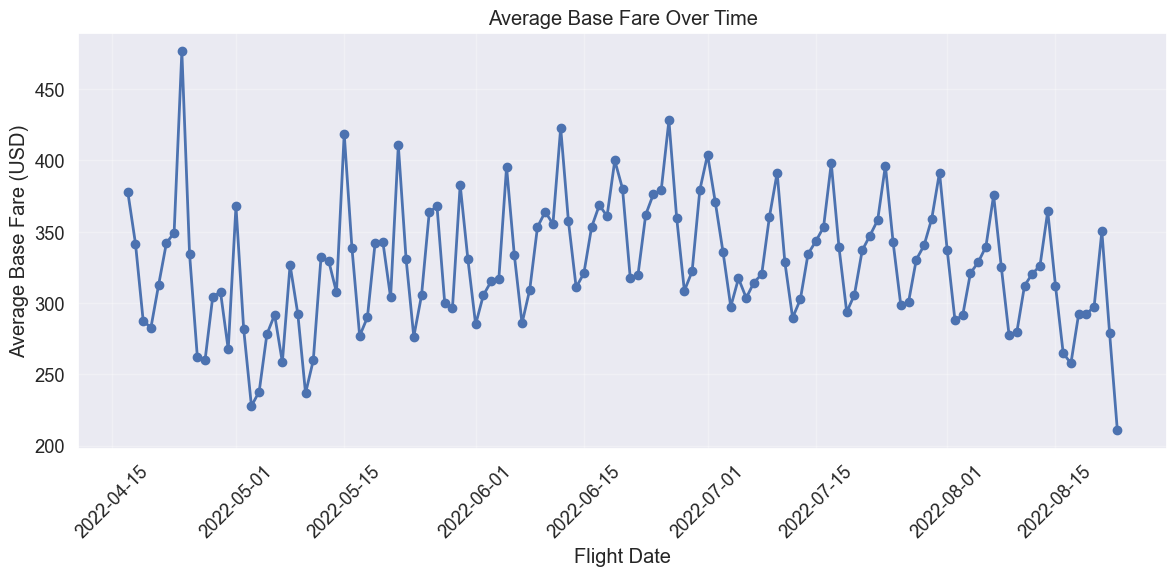

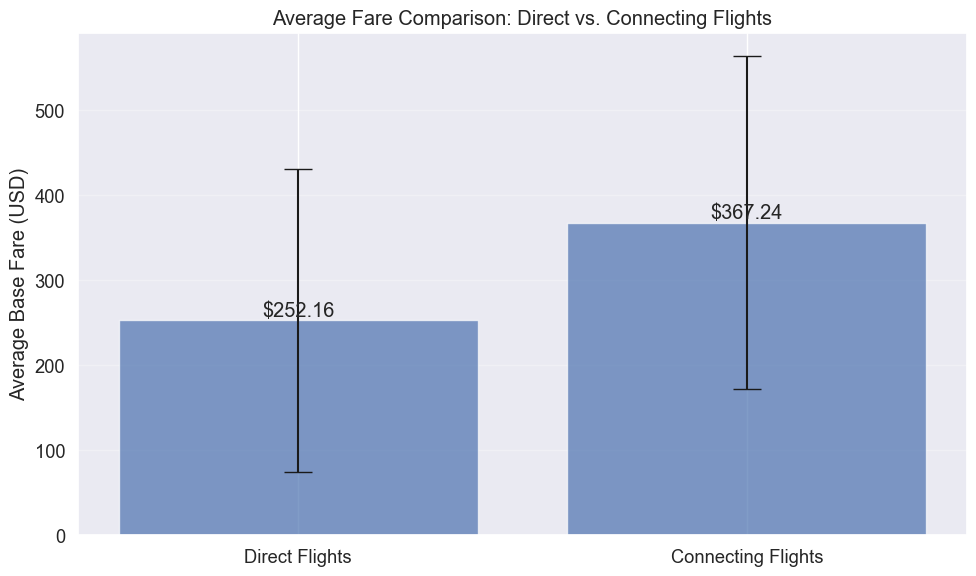

C:\Users\yongj\AppData\Local\Temp\ipykernel_25168\708378288.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(boxplot_data, labels=seat_labels, vert=True)


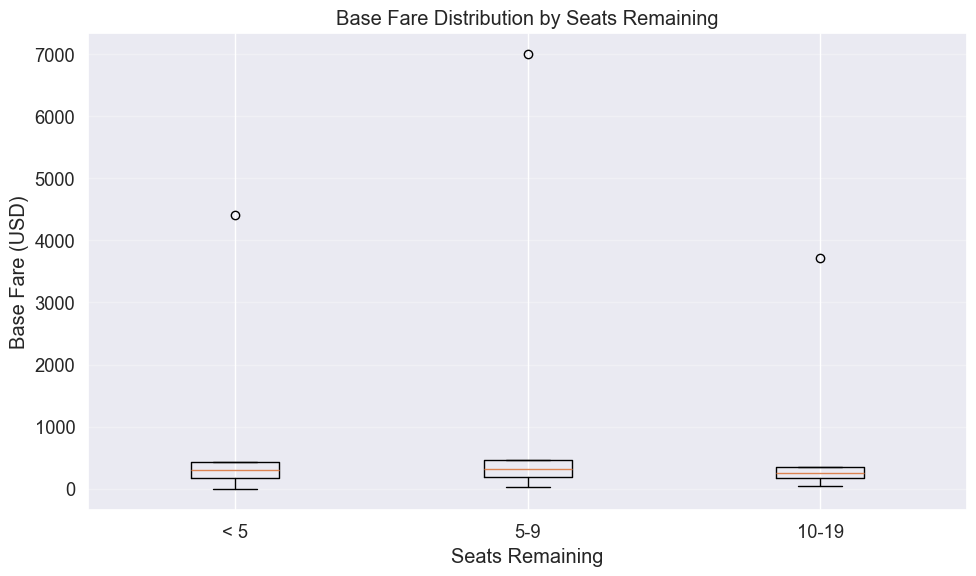

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.

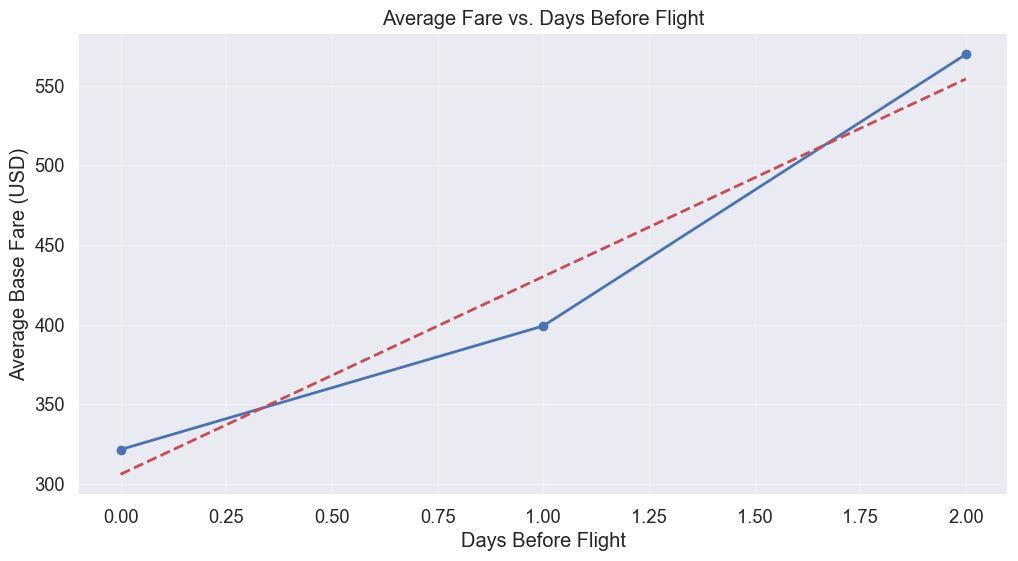

In [ ]:


# 8. Create fare comparison for direct vs. connecting flights
if 'isNonStop' in flight_df.columns and 'baseFare' in flight_df.columns: 
    
    # Group data by flight type
    flight_types = flight_df.groupBy("isNonStop") \
                         .agg(
                             F.count("*").alias("count"),
                             F.avg("baseFare").alias("avgFare"),
                             F.stddev("baseFare").alias("stddevFare")
                         ) \
                         .collect()
    
    # Extract data
    labels = [f"{'Direct' if row['isNonStop'] else 'Connecting'} Flights" for row in flight_types]
    avg_fares = [row["avgFare"] for row in flight_types]
    std_fares = [row["stddevFare"] if row["stddevFare"] is not None else 0 for row in flight_types]
    
    # Create bar chart with error bars
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, avg_fares, yerr=std_fares, capsize=10, alpha=0.7)
    ax.set_title('Average Fare Comparison: Direct vs. Connecting Flights')
    ax.set_ylabel('Average Base Fare (USD)')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(avg_fares):
        ax.text(i, v + 5, f"${v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show() 
    
    # Extract data for boxplot
    seat_labels = [row["seatGroup"] for row in seat_stats]
    boxplot_data = []
    for row in seat_stats:
        q1, median, q3 = row["percentiles"]
        min_val, max_val = row["minFare"], row["maxFare"]
        boxplot_data.append([min_val, q1, median, q3, max_val])
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(boxplot_data, labels=seat_labels, vert=True)
    ax.set_title('Base Fare Distribution by Seats Remaining')
    ax.set_xlabel('Seats Remaining')
    ax.set_ylabel('Base Fare (USD)')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 10. Create a heatmap of day-to-flight price correlation
if 'elapsedDays' in flight_df.columns and 'baseFare' in flight_df.columns: 
    
    # Make sure elapsedDays is numeric
    numeric_df = flight_df.filter(F.col("elapsedDays").isNotNull())
    
    # Group by days before flight
    elapsed_stats = numeric_df.groupBy("elapsedDays") \
                           .agg(F.avg("baseFare").alias("avgFare")) \
                           .orderBy("elapsedDays") \
                           .collect()
    
    # Extract data
    elapsed_days = [row["elapsedDays"] for row in elapsed_stats]
    avg_fares = [row["avgFare"] for row in elapsed_stats]
    
    # Create line chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(elapsed_days, avg_fares, marker='o', linestyle='-', linewidth=2)
    ax.set_title('Average Fare vs. Days Before Flight')
    ax.set_xlabel('Days Before Flight')
    ax.set_ylabel('Average Base Fare (USD)')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    if len(elapsed_days) > 1:
        z = np.polyfit(elapsed_days, avg_fares, 1)
        p = np.poly1d(z)
        ax.plot(elapsed_days, p(elapsed_days), "r--", linewidth=2)
        
        # Add trend direction annotation
        trend = "increases" if z[0] > 0 else "decreases"
        ax.text(0.05, 0.95, f"Trend: Price {trend} by ${abs(z[0]):.2f} per day", 
                transform=ax.transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

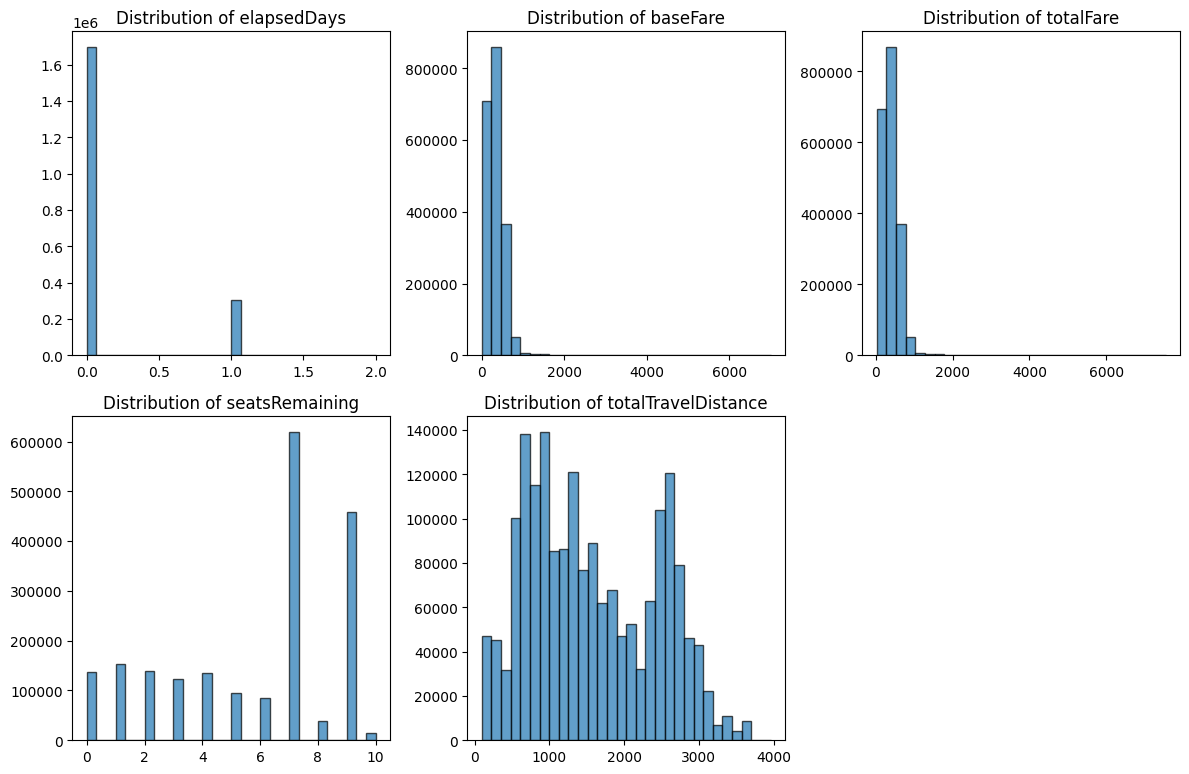

In [5]:
# Select only numeric columns
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Plot histograms directly from PySpark DataFrame
plt.figure(figsize=(12, 8))

for i, col_name in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)  # Creates a grid of subplots

    # Collect data from PySpark DataFrame
    data = flight_df.select(col_name).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

    # Plot histogram
    plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()

In [6]:
# Select only numeric columns and convert to double
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Convert integer columns to double (required for Correlation.corr)
for col_name in numeric_cols:
    flight_df = flight_df.withColumn(col_name, col(col_name).cast("double"))

# Assemble numeric columns into a feature vector
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(flight_df).select(vector_col)

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()

# Plot heatmap directly
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=numeric_cols, yticklabels=numeric_cols)

plt.title("Correlation Matrix")
plt.show()

NameError: name 'VectorAssembler' is not defined